# Compute Word Vectors using TruncatedSVD in Amazon Food Reviews.
Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454 Number of users: 256,059 Number of products: 74,258 Timespan: Oct 1999 - Oct 2012 Number of Attributes/Columns in data: 10

Attribute Information:

1.  index
2.  Id
3.  ProductId - unique identifier for the product
4.  UserId - unqiue identifier for the user
5.  ProfileName
6.  HelpfulnessNumerator - number of users who found the review helpful
7.  HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
8.  Score - rating between 1 and 5
9.  Time - timestamp for the review
10. Summary - brief summary of the review
11. Text - text of the review
12. ProcessedText - Cleaned & Preprocessed Text of the review

**Objective: Perform following tasks on Amazon Food reviews:**<br>

**Task 1. Sample 25000 reviews then find top 10000 words corresponding to top 10000 Inverse Document Frequency(IDF) values.**<br>
**Task 2. Compute co-occurrence matrix on those 10000 words.** <br>
**Task 3. Find optimal value of number of components(reduced dimensions) using maximum variance.**<br>
**Task 4. Apply TruncatedSVD using optimal value of number of components.**<br>
**Task 5. Cluster words using K-Means.**<br>

[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

Loading the data

SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently. Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [173]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import StandardScaler

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.utils.extmath import randomized_svd

In [174]:
connection = sqlite3.connect('FinalAmazonFoodReviewsDataset.sqlite')

data = pd.read_sql_query("SELECT * FROM Reviews", connection)
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...


In [175]:
print(data.shape)
print(data["Score"].value_counts())

(364171, 12)
Positive    307061
Negative     57110
Name: Score, dtype: int64


In [176]:
stop = set(stopwords.words("english")) #set of stopwords
sno = nltk.stem.SnowballStemmer("english")
print(stop)

{'against', 'couldn', 're', 't', "won't", 'i', "that'll", 'ain', 'its', 'up', 'isn', 'from', 'yours', 'doesn', 'or', 'why', 'haven', 'between', 'me', 'that', 'weren', 'what', 'not', 'other', 'm', "you'd", 'we', 'been', 'theirs', 'she', 'they', 'out', "should've", 've', "doesn't", 'mightn', 'on', "it's", 'such', 'about', "hadn't", 'hasn', 'herself', 'has', 'all', "she's", "you'll", "weren't", 'myself', 'above', 'him', 'below', 'does', 'his', 'very', "hasn't", 's', 'just', 'this', 'of', 'o', 'it', 'do', "mightn't", 'the', 'through', 'own', 'no', 'only', "didn't", 'down', 'any', 'your', 'didn', 'y', 'mustn', 'himself', 'should', 'needn', 'our', 'under', 'there', 'some', 'as', 'my', 'because', 'until', 'when', "you've", "aren't", 'was', 'then', 'itself', 'shouldn', "mustn't", 'few', 'her', 'over', 'd', 'll', 'by', 'having', 'he', "haven't", 'don', 'than', 'once', 'each', 'for', 'will', 'won', "shan't", 'shan', "wasn't", 'can', 'at', 'these', 'and', 'wouldn', 'themselves', 'being', 'same', 

In [177]:
def cleanhtml(sentence): #function to clean htmltags
    cleanr = re.compile("<.*?>")
    cleantext = re.sub(cleanr, " ", sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [178]:
#Code for removing stop-words from 'Text' column

i = 0
final_string = []
s = ""
for sentence in data["Text"].values:
    filteredSentence = []
    EachReviewText = ""
    sentenceHTMLCleaned = cleanhtml(sentence)
    for eachWord in sentenceHTMLCleaned.split():
        for sentencePunctCleaned in cleanpunc(eachWord).split():
            if (sentencePunctCleaned.isalpha()) & (len(sentencePunctCleaned)>2):
                if sentencePunctCleaned.lower() not in stop:
                    sentenceLower = sentencePunctCleaned.lower()
                    s = (sno.stem(sentenceLower))
                    filteredSentence.append(s)
                     
    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [179]:
data["CleanedText"] = final_string

In [180]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText,CleanedText
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,have bought sever the vital can dog food produ...,bought sever vital can dog food product found ...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arriv label jumbo salt peanut the pean...,product arriv label jumbo salt peanut peanut a...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,this confect that has been around few centuri ...,confect around centuri light pillowi citrus ge...
3,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffi great price there was wide assort ...,great taffi great price wide assort yummi taff...
4,5,6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,Positive,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...,got wild hair for taffi and order this five po...,got wild hair taffi order five pound bag taffi...


## Task 1. Sample 25000 reviews then find top 10000 words corresponding to top 10000 Inverse Document Frequency(IDF) values.

In [181]:
#taking 25000 random samples
Data = data.sample(n = 25000)
Data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,ProcessedText,CleanedText
316493,455533,492508,B0000YUTUW,A2QNPL3DCV5ITK,L. Such,0,0,Negative,1244332800,Not what I thought for the price,"I was disappointed, the suckers are about 1 to...",was disappoint the sucker are about that and t...,disappoint sucker stick plastic thought least ...
73322,104508,113463,B000FL08B0,A109L3WXD1SJFU,"Cookbook Gal ""Cookbook Gal""",0,0,Positive,1212019200,"Great product, poorly packaged","After reading a previous review, I was excited...",after read previous review was excit find out ...,read previous review excit find compani solv p...
323959,466801,504764,B000H241DS,A1SQZTQCLKWTED,Ella B.,2,5,Negative,1323993600,Poor Quality Control,I gave this product poor reviews because they ...,gave this product poor review becaus they not ...,gave product poor review allow return yet prod...
176289,249921,270984,B000EQSAIY,A3M91P9K64YADW,carol998,0,0,Positive,1320019200,What a wonderful flavor,as a finishing salt. Never have tasted a salt...,finish salt never have tast salt with subtl al...,finish salt never tast salt subtl almost sweet...
330298,476046,514800,B000CSEFQ0,A2B1I205ZNBVLY,Rudy Bonn,2,3,Negative,1347062400,What is in it?,Kellogg's cereals contain genetically modified...,kellogg cereal contain genet modifi organ thos...,kellogg cereal contain genet modifi organ crop...


In [182]:
print(Data.shape)
print(Data["Score"].value_counts())

(25000, 13)
Positive    21060
Negative     3940
Name: Score, dtype: int64


In [183]:
TFIDF_Vec= TfidfVectorizer(ngram_range=(1,1), stop_words = "english")
TFIDF_Count = TFIDF_Vec.fit_transform(Data["CleanedText"].values)

In [184]:
TFIDF_Count.shape

(25000, 19690)

In [185]:
features = TFIDF_Vec.get_feature_names()

In [186]:
idfValues = TFIDF_Vec.idf_

In [189]:
d = dict(zip(features, 11 - idfValues))

In [190]:
sortedDict = sorted(d.items(), key = lambda d: d[1], reverse = True)
#here we are sorting a dictionary where first value(keys) are words and second value(values) are IDF values. There is a 'key'
#argument in sorted function takes a function which will be used to determine according to what values to sort by. Here, we have
#given an anonymous function which takes the data followed by colon then d[1] means in our data second value is idf values so we
#are telling the sorted function to sort the dictionary according to idf values.

In [191]:
sortedDict = sortedDict[0:10000]
#taking top 10000 words corresponding to top 10000 Inverse Document Frequency(IDF) values.

In [192]:
len(sortedDict)

10000

In [194]:
for i in range(10):
    print(sortedDict[i])

('like', 8.864144163134325)
('tast', 8.83904668593449)
('good', 8.69756551429628)
('love', 8.628436018583539)
('great', 8.60288776650821)
('flavor', 8.58575987042638)
('product', 8.55654487219033)
('use', 8.49829968053931)
('tri', 8.478532965688592)
('make', 8.317306026034618)


In [195]:
for i in range(10):
    print(sortedDict[i][0])

like
tast
good
love
great
flavor
product
use
tri
make


In [196]:
wordList_idf = []
for i in range(len(sortedDict)):
    wordList_idf.append(sortedDict[i][0])

In [197]:
len(wordList_idf)

10000

## Task 2. Compute co-occurrence matrix on those 5000 words.

In [198]:
Data["CleanedText"].head()

316493    disappoint sucker stick plastic thought least ...
73322     read previous review excit find compani solv p...
323959    gave product poor review allow return yet prod...
176289    finish salt never tast salt subtl almost sweet...
330298    kellogg cereal contain genet modifi organ crop...
Name: CleanedText, dtype: object

In [199]:
sent = Data["CleanedText"].iloc[3]
sent

'finish salt never tast salt subtl almost sweet flavor put spare finish toss salad fish edaman winter squash potato sweet white truli gem first tri year ago ran couldnt find anywher bought give gift thank'

In [200]:
len(sent.split())

35

In [201]:
#checking for any empty text
cnt = 0
for i in Data["CleanedText"]:
    cnt += 1
    if len(i.split()) == 0:
        print(cnt)

In [202]:
def co_occurrence(sentence_array, window_size, word_list):
    
    co_occ = np.zeros((len(word_list), len(word_list)), dtype = int)
    
    for i in sentence_array:
        for word in i.split():
            if word in word_list:
                row = word_list.index(word)   #this will give index of a word in word_list array
                wordIndexInSentence = i.split().index(word)  #this will give index of a word in sentence 'i'
                
                window_left = wordIndexInSentence - window_size
                if window_left < 0:
                    window_left = 0
                    
                window_right = wordIndexInSentence + window_size
                if window_right > len(i.split()):
                    window_right = len(i.split())
                    
                for context_word in i.split()[window_left:window_right]:
                    if context_word in word_list:
                        column = word_list.index(context_word)
                        co_occ[row][column] += 1
    return co_occ

#this is a function to create co-occurrence matrix of all the words which will be passed into "word_list" argument.
#basically this function takes three arguments: 

#First: "sentence_series"(numpy ndarray) which is an array which should contain all the reviews/sentences. 

#Second: "window_size"(integer) this determines the context size upto which you may want to find the co-occurring words.

#Third: "word_list"(list) this should contain list of words which you may want to find as co-occurring.

#it returns co-occurrence matrix which is a square matrix and each row and column corresponds to a word as defined in 
#"word_list"

In [204]:
sent_series = Data["CleanedText"].values
print(type(sent_series))
print(sent_series.shape)

<class 'numpy.ndarray'>
(25000,)


In [205]:
print(len(wordList_idf))

10000


In [206]:
co_occur_matrix = co_occurrence(sent_series, 5, wordList_idf)

In [207]:
print(co_occur_matrix)
print(co_occur_matrix.shape)

[[13064  3063   890 ...     0     0     0]
 [ 2905 12236  1889 ...     0     3     0]
 [  956  1898  9816 ...     0     0     0]
 ...
 [    0     0     0 ...     2     0     0]
 [    0     1     0 ...     0     2     0]
 [    0     0     0 ...     0     0     2]]
(10000, 10000)


## Task 3. Find optimal value of number of components(reduced dimensions) using maximum variance.

In [210]:
k = [i for i in range(20,241,20)]
components = []
total_var = []

for j in k:
    svd = TruncatedSVD(n_components=j, n_iter=10)
    svd.fit(co_occur_matrix)
    var_perc = sum(svd.explained_variance_ratio_)
    components.append(j)
    total_var.append(var_perc)
    
xy = list(zip(components, total_var))
xy

[(20, 0.680916805693981),
 (40, 0.7795932630180603),
 (60, 0.8274989266485523),
 (80, 0.8606353176834907),
 (100, 0.8838791551841226),
 (120, 0.9007604176008285),
 (140, 0.9140905587270168),
 (160, 0.9252313729437507),
 (180, 0.9340579389749889),
 (200, 0.9413266320118187),
 (220, 0.9473163368196609),
 (240, 0.952410173701445)]

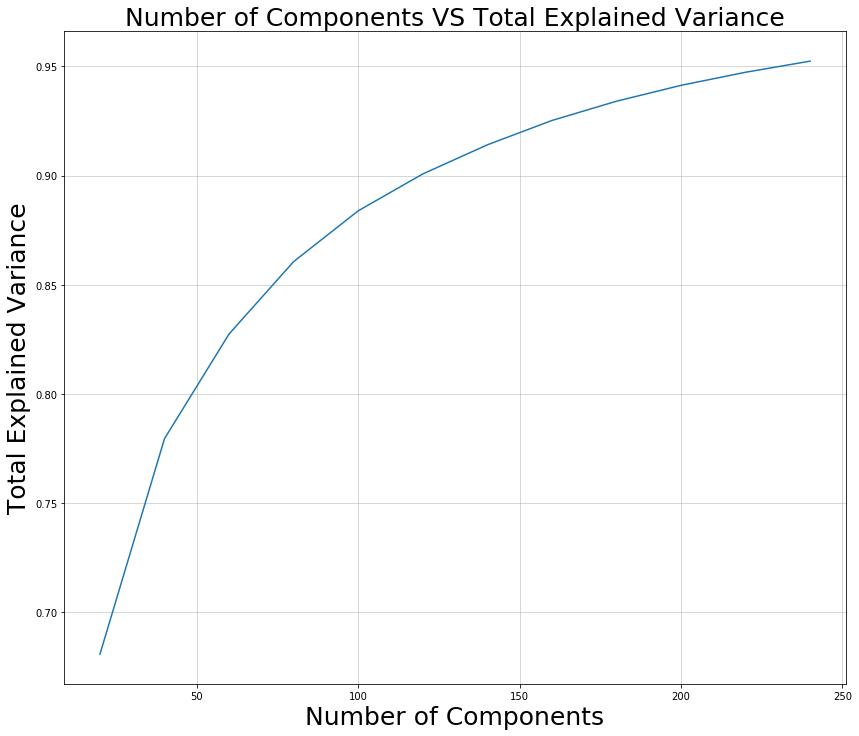

In [211]:
plt.figure(figsize = (14, 12))
plt.plot(components, total_var)
plt.title("Number of Components VS Total Explained Variance", fontsize=25)
plt.xlabel("Number of Components", fontsize=25)
plt.ylabel("Total Explained Variance", fontsize=25)
plt.grid(linestyle='-', linewidth=0.5)

**We can see from the graph that we are getting approximately 91% variance at number of components equal to 140. It further means that we are preserving 91% of data even by reducing our dimension from 5000 to 140. Therefore, we are considering our number of components to be 140**

## Task 4. Apply TruncatedSVD using optimal value of number of components.

In [218]:
svd = TruncatedSVD(n_components = 140, n_iter = 10)
svd.fit(co_occur_matrix)
var_perc = sum(svd.explained_variance_ratio_)
print("Percentage of variance explained = "+str(var_perc * 100)+"%")

Percentage of variance explained = 91.40980500709482%


In [219]:
U, Sigma, VT = randomized_svd(co_occur_matrix, n_components = 140, n_iter = 10)
U.shape

(10000, 140)

## Task 5. Cluster words using K-Means.

In [222]:
Data_Std = StandardScaler(with_mean = False).fit_transform(U)
print(Data_Std.shape)
print(type(Data_Std))

(10000, 140)
<class 'numpy.ndarray'>


In [223]:
#taking number of cluster = 1000
KMeans_Apply = KMeans(n_clusters=1000, init = "k-means++", max_iter = 100, n_jobs = -1).fit(Data_Std)

In [240]:
Cluster_indices = {i: np.where(KMeans_Apply.labels_ == i) for i in range(KMeans_Apply.n_clusters)}

### Checking for similarity of words in clusters manually

In [234]:
#checking for review 981
for i in Cluster_indices[981][0]:
    print(wordList_idf[i])

understand
sorri
hesit
warn
despit
talk
trust
rare
post
skeptic
regard
trap
earlier
vine
titl
wrote
sampler
mislead
refer
deserv
advic
convinc
ignor
accur
listen
written
error
edit
critic
slim
subject
disagre
fda
video
copi
jim
glow
influenst
rebecca
lingonberri


**Now in cluster number 981, the above words are related like: understand, sorri, hesit, disagre, error, edit, written, convinc etc**

In [237]:
#checking for review 954
for i in Cluster_indices[954][0]:
    print(wordList_idf[i])

sort
grew
favor
popular
sister
peppermint
assort
everywher
parent
reach
cute
hadnt
memori
purs
childhood
section
theyll
tub
dad
dispens
wrapper
watermelon
germani
lollipop
haribo
law
henc
halloween
display
cowork
dye
oversea
valentin
vend
crate
jolli
nausea
cigarett
wilton
butterscotch
rancher
surf
buffet
belt
judi


**Now in cluster number 954, the above words are related like: parent, childhood, cute, sister, memori, cigarett, nausea, butterscotch,peppermint etc**

In [238]:
#checking for review 925
for i in Cluster_indices[925][0]:
    print(wordList_idf[i])

plenti
job
appreci
supplement
upset
besid
period
prevent
medicin
relax
excess
sooth
loss
rid
diseas
settl
hurt
timothi
tummi
maintain
suspect
appetit
soften
dental
decis
fight
leg
track
properti
stress
symptom
med
watcher
phone
reflux
hunger
immun
arthriti
regul
antibiot
curb
heal
vote
plaqu
listmania
thyroid
mastic


**Now in cluster number 925, the above words are related like: upset, relax, stress, diseas, symptom, antibiot, heal, thyroid, immun etc**

In [239]:
#checking for review 904
for i in Cluster_indices[904][0]:
    print(wordList_idf[i])

admit
power
strang
initi
disgust
gross
distinct
spoil
funni
kinda
butteri
attract
spray
compliment
familiar
detect
yuck
crap
dead
fragranc
welcom
stink
harsh
earthi
gag
appet
linger
divin
faint
sweat
potent
rabbit
bergamot
stinki
lavend
margarita
pungent
sniff
offens
pellet
deodor
overweight
whiff
pee
waft
potti
salami
soapi
deterg


**Now in cluster number 904, the above words are related like: disgust, gross, spoil, yuck, crap, pungent, harsh, stink, fragranc, lavend etc**